In [1]:
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from matplotlib.animation import FuncAnimation

from modules import compute_neighbors, density, accel, energy

In [2]:
# Constants
npart = 1000                        # Number of particles
#mpart = 0.002
# Comment out line above and uncomment line below to do standard shock tube test
mpart = 0.00125                     # Particle mass
ho = 0.005                           # Initial smoothing length
#gamma = 1.0
# Comment out line above and uncomment line below once you've added an energy equation
gamma = 1.66667                     # Adiabatic index

# Time-stepping parameters
dt = 0.0001                         # Time step
nstep = 1000                        # Number of time steps

# Array initialization
x = np.zeros(npart)                 # Particle positions
mass = np.zeros(npart)              # Particle masses
v = np.zeros(npart)                 # Particle velocities
dens = np.zeros(npart)              # Particle densities
ee = np.zeros(npart)                # Internal energy
Press = np.zeros(npart)             # Pressure
acc = np.zeros(npart)               # Acceleration
soundspeed = np.zeros(npart)        # Sound speed
edot = np.zeros(npart)              # Time derivative of internal energy
smooth = np.zeros(npart)            # Smoothing length
nneigh = np.zeros(npart,dtype=int)  # Number of neighbors
neighlist = np.zeros((npart,npart), dtype=int) # Neighbor list

In [3]:
x[0] = -1.0
#v[0] = 2.5
#ee[0] = 0.3
# Comment out two lines above and uncomment two lines below to do standard shock tube test
v[0] = 0.0
ee[0] = 1.5
smooth[0] = ho
for i in range(1,npart):
  if (x[i-1] < 0.0):
     #x[i] = x[i-1] + 1.0/(0.7*npart)
     #ee[i] = 0.3
     #v[i] = 2.5
# Comment out 3 lines above and uncomment 3 lines below for standard shock tube test       
     x[i] = x[i-1] + 1.0/(0.8*npart)
     ee[i] = 1.5
     v[i] = 0.0
  if (x[i-1] >= 0.0):
     #x[i] = x[i-1] + 1.0/(0.3*npart)
     #ee[i] = 0.3
     #v[i] = 0.0 
# Comment out 3 lines above and uncomment 3 lines below for standard shock tube test      
     x[i] = x[i-1] + 1.0/(0.2*npart)
     ee[i] = 1.0
     v[i]=0.0
  smooth[i] = ho

In [4]:
# Calculate initial densities
nneigh[:] = npart
neighlist[:] = np.arange(npart)
dens[:] = [density(i, x, smooth, nneigh, neighlist, mpart) for i in range(npart)]

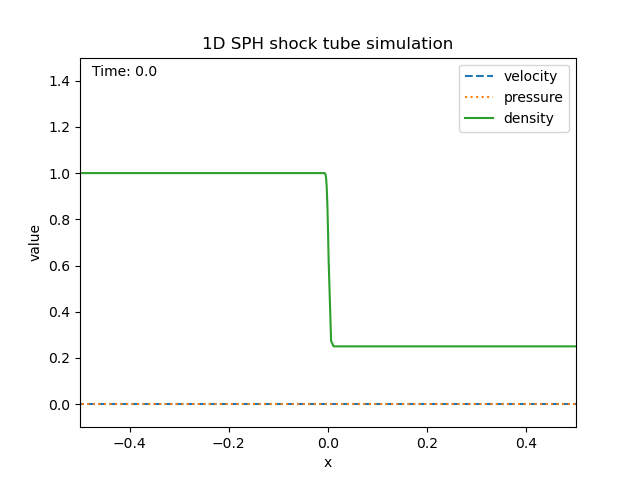

In [5]:
# Initialise figure
fig, ax = plt.subplots()
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.1,10.0)
# Uncomment line above and comment out line below once you've added the energy equation
#ax.set_ylim(-0.1,5.0)
# Uncomment line above and comment out line below to do the standard shock tube test
ax.set_ylim(-0.1, 1.5)
ax.set_xlabel('x')
ax.set_ylabel('value')
ax.set_title('1D SPH shock tube simulation')

# Initialise lines and timestamp
line_v, = ax.plot(x, v, ls='dashed', label='velocity')
line_Press, = ax.plot(x, Press, ls='dotted', label='pressure')
line_dens, = ax.plot(x, dens, label='density')
#line_ee, = ax.plot(x,ee, ls='dashdot', label='internal energy')
text_time = ax.text(0.025, 0.95, 'Time: 0.0', transform=ax.transAxes)

# Time integration - Main loop
def update(j):
  global x, v, ee, smooth, nneigh, neighlist, dens, Press, soundspeed, acc, edot
  # Update global quantities
  smooth = ho / dens**(1.0/3.0)
  nneigh, neighlist = compute_neighbors(x, smooth, npart)
  dens = np.array([density(i, x, smooth, nneigh, neighlist, mpart) for i in range(npart)])
  Press = dens*ee
  if (gamma > 1.0):  
    Press = (gamma - 1.0) * Press
  soundspeed = np.sqrt(gamma * Press / dens)

  # Update quantities for each particle
  for i in range(0,npart):
    acc[i] = accel(i, x, v, soundspeed, dens, Press, smooth, nneigh, neighlist, mpart)
    v[i] = v[i] + acc[i]*dt/2.0
    dens[i] = density(i, x+v[i]*dt/2.0, smooth, nneigh, neighlist, mpart)
    edot[i] = energy(i, x+v[i]*dt/2.0, v, soundspeed, dens, Press, smooth, nneigh, neighlist, mpart)
    x[i] = x[i] + v[i]*dt
    ee[i] = ee[i] + edot[i]*dt
    v[i] = v[i] + acc[i]*dt/2.0

  # Update plot
  line_v.set_ydata(v)
  line_v.set_xdata(x)  
  line_Press.set_ydata(Press)
  line_Press.set_xdata(x)  
  line_dens.set_ydata(dens) 
  line_dens.set_xdata(x)  
#  line_ee.set_ydata(ee)  
  text_time.set_text(f'Time: {j*dt:.4f}')
  return line_v, line_Press, line_dens

ani = FuncAnimation(fig, update, frames=range(nstep),repeat=False)
ax.legend(loc='upper right')
plt.show()

# To print out final hydro variable values, uncomment the lines below
#for i in range(0,npart):
    #if ((x[i] > -0.2) and (x[i] < 0.4)):
       #print(i,x[i],dens[i],v[i],Press[i],ee[i])